In [55]:
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from time import time

## Arranging dataset for Pytorch dataset reader
Facial Expression Dataset: http://tdface.ece.tufts.edu/downloads/TD_RGB_E/

In [ ]:
import os
dataset_path = '/home/goktug/projects/facial_expressions/model/trainer/dataset/dataset_'
output_path = '/home/goktug/projects/facial_expressions/model/trainer/dataset'
for id_person, folder_name in enumerate(os.listdir(dataset_path)):
    if folder_name == '47':
        continue
    path_single_person_images = dataset_path + '/' + folder_name
    for id_image, image_name in enumerate(os.listdir(path_single_person_images)):
        image = Image.open(os.path.join(folder_name,path_single_person_images,image_name))
        if image_name == "TD_RGB_E_1.jpg":
            image.save(output_path + '/' + 'neutral' + '/' + str(id_person) + '.jpg')
        if image_name == "TD_RGB_E_2.jpg":
            image.save(output_path + '/' + 'smile' + '/' + str(id_person) + '.jpg')
        if image_name == "TD_RGB_E_3.jpg":
            image.save(output_path + '/' + 'eye_closed' + '/' + str(id_person) + '.jpg')
        if image_name == "TD_RGB_E_4.jpg":
            image.save(output_path + '/' + 'shocked' + '/' + str(id_person) + '.jpg')
        if image_name == "TD_RGB_E_5.jpg":
            image.save(output_path + '/' + 'sunglass' + '/' + str(id_person) + '.jpg')

### Parameters

In [56]:
lr=0.001
epoch_count=30
train_ratio=0.9
train_batch_size=5
validation_batch_size=5
test_batch_size=5
num_classes=5

### Transfer Learning with Pre-trained ResNet

In [57]:
device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda:0")
model = models.resnet50(pretrained=True)
for isim, param in model.named_parameters():
    if 'layer4' not in isim:
        param.requires_grad = False
model.fc = torch.nn.Linear(2048, num_classes) 
model = model.to(device_gpu)

### Load Dataset
#### There is no sufficient data. I gave the test set up!

In [58]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # resnet girişi
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
dataset = datasets.ImageFolder('./dataset', transform = train_transforms)
print("Class and Label Ids:",dataset.class_to_idx)

dataset_size = len(dataset)
train_set_size = int(dataset_size * train_ratio)
validation_set_size = dataset_size-train_set_size

print("Training set size:", train_set_size)
print("Validation set size:", validation_set_size)

train_set, validation_set= torch.utils.data.random_split(dataset, [train_set_size, validation_set_size])
    
train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle=True, drop_last=True)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size = validation_batch_size, shuffle=True, drop_last=True)
    
train_loader = [batch for batch in train_loader]
train_batch_count = len(train_loader)
print("Traning Set Batch Count:",train_batch_count)
print("Training Set Batch Size:",train_batch_size)
   
validation_loader = [batch for batch in validation_loader]
validation_batch_count = len(validation_loader)
print("Validation Set Batch Count:",validation_batch_count)
print("Validation Set Batch Size:",validation_batch_size)

Class and Label Ids: {'eye_closed': 0, 'neutral': 1, 'shocked': 2, 'smile': 3, 'sunglass': 4}
Training set size: 504
Validation set size: 56
Traning Set Batch Count: 100
Training Set Batch Size: 5
Validation Set Batch Count: 11
Validation Set Batch Size: 5


### Visualize the Image

torch.Size([3, 224, 224])


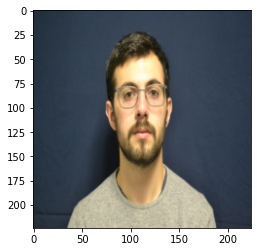

In [59]:
batch_id = 12
data_id = 3
x = train_loader[batch_id][0][data_id]
print(x.shape)
z = x * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
z = z + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
img = transforms.ToPILImage(mode='RGB')(z)
plt.imshow(img)

### Training on My Sweet GPU :)

In [60]:
training_loss_list = []
validation_loss_list = []
training_accuracy_list = []
validation_accuracy_list = []
train_error_list = []
validation_error_list = []

        
def TrueCount(pred, y_true, epoch, batch_id, set_type):
    true_count = 0
    for i in range(pred.size(0)):
        if torch.argmax(pred[i]).item()==y_true[i].item():
            true_count += 1

        else:#yanlış tahmin yaptıysa ve son epochta ise:
            if epoch==epoch_count-1:
                vector = [batch_id, i, torch.argmax(pred[i]).item(), y_true[i].item()]
                if set_type == "train":
                    train_error_list.append(vector)
                if set_type == "validation":
                    validation_error_list.append(vector)
                if set_type == "test":
                    test_error_list.append(vector)
    return true_count    
    
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
t = time()
    
for epoch in range(epoch_count):
        
    training_loss = 0
    toplam = 0
    dogru = 0
        
    for batch_id in range(len(train_loader)):
        X,y = train_loader[batch_id]
        X,y = X.to(device), y.to(device)

        model.train()
        optimizer.zero_grad()
        cikti = model(X)
        loss = criterion(cikti, torch.tensor(y, dtype=torch.long))
        training_loss += loss.item()
        loss.backward()
        optimizer.step()

        #Evaluation
        with torch.no_grad():
            model.eval()
            cikti = model(X)
            dogru = dogru + TrueCount(cikti,y,epoch,batch_id,"train")
            toplam = toplam + y.size(0)
                
    training_accuracy = (dogru/toplam)*100
    training_loss = training_loss/train_batch_count
    training_loss_list.append(training_loss)  
    training_accuracy_list.append(training_accuracy)
    print("Epoch {} | Training Loss: {} | Training Accuracy: {}%".format(epoch,training_loss,str(training_accuracy)))  
    print("Geçen süre: {} mins".format(round((time() - t) / 60, 2)))
    #****************************************************************************     
        
        
    validation_loss = 0
    toplam = 0
    dogru = 0                    
    for batch_id in range(len(validation_loader)): 
        X,y = validation_loader[batch_id]
        X,y = X.to(device), y.to(device)
        with torch.no_grad():
            model.eval()
            cikti = model(X)
            loss = criterion(cikti, torch.tensor(y, dtype=torch.long))
            validation_loss += loss.item() 
            dogru = dogru + TrueCount(cikti,y,epoch,batch_id,"validation")
            toplam = toplam + y.size(0)
                
    validation_accuracy = (dogru/toplam)*100
    validation_loss = validation_loss/validation_batch_count
    validation_loss_list.append(validation_loss)  
    validation_accuracy_list.append(validation_accuracy)
    print("Epoch {} | Validation Loss: {} | Validation Accuracy: {}%".format(epoch,validation_loss,str(validation_accuracy))) 
    print("Geçen süre: {} mins".format(round((time() - t) / 60, 2)))
    #****************************************************************************      
        
    #Save the model
    model = model.to(device_cpu)
    checkpoint = {'model': model, 'state_dict': model.state_dict(),'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'Epoch {}.pth'.format(epoch))
    print("Model kaydedildi.")
    print("**********************************************************")
    model = model.to(device_gpu)
    
model = {}
    
model['training_loss_list'] = training_loss_list
model['validation_loss_list'] = validation_loss_list
model['training_accuracy_list'] = training_accuracy_list
model['validation_accuracy_list'] = validation_accuracy_list
model['train_error_list'] = train_error_list
model['validation_error_list'] = validation_error_list
model['train_loader'] = train_loader
model['validation_loader'] = validation_loader

<ipython-input-60-187a7b394e5f>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(cikti, torch.tensor(y, dtype=torch.long))


Epoch 0 | Training Loss: 1.3765772143006325 | Training Accuracy: 54.2%
Geçen süre: 0.17 mins


<ipython-input-60-187a7b394e5f>:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(cikti, torch.tensor(y, dtype=torch.long))


Epoch 0 | Validation Loss: 1.270060821013017 | Validation Accuracy: 50.90909090909091%
Geçen süre: 0.18 mins
Model kaydedildi.
**********************************************************
Epoch 1 | Training Loss: 0.8621958190202713 | Training Accuracy: 77.4%
Geçen süre: 0.35 mins
Epoch 1 | Validation Loss: 0.6477419300512834 | Validation Accuracy: 80.0%
Geçen süre: 0.36 mins
Model kaydedildi.
**********************************************************
Epoch 2 | Training Loss: 0.581779650375247 | Training Accuracy: 86.4%
Geçen süre: 0.53 mins
Epoch 2 | Validation Loss: 0.5339411188932982 | Validation Accuracy: 81.81818181818183%
Geçen süre: 0.54 mins
Model kaydedildi.
**********************************************************
Epoch 3 | Training Loss: 0.42430484931915996 | Training Accuracy: 90.0%
Geçen süre: 0.71 mins
Epoch 3 | Validation Loss: 0.4652845375239849 | Validation Accuracy: 83.63636363636363%
Geçen süre: 0.72 mins
Model kaydedildi.
**********************************************

### Test with saved model

3


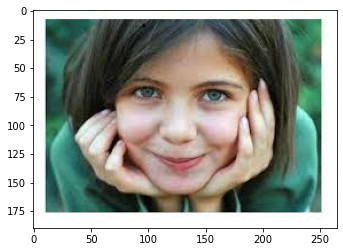

In [66]:
def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = "/home/goktug/projects/facial_expressions/model/Epoch 7.pth" 
model = load_checkpoint(filepath)

train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # resnet girişi
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

test_im = Image.open("/home/goktug/projects/facial_expressions/model/test.jpg")
plt.imshow(test_im)
test_im = train_transforms(test_im)
test_im = test_im.unsqueeze(0) #dimension expansion for batch
print(torch.argmax(model(test_im)).item())
#{'Eye Closed': 0, 'Neutral': 1, 'Shocked': 2, 'Smile': 3, 'Sunglass': 4}

### Export the model to an ONNX file in order to use with TensorRT C++ API

In [67]:
import torch.onnx
# Export the model
filepath = "/home/goktug/projects/facial_expressions/model/Epoch 7.pth" 
model = load_checkpoint(filepath)
dummy_input = torch.randn(1, 3, 224, 224, requires_grad=True)

output = torch.onnx.export(model, 
                          dummy_input, 
                          "/home/goktug/projects/facial_expressions/model/facial_expression_model.onnx", 
                          verbose=False)